In [2]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Function to run experiment and extract accuracy & epsilon
def run_experiment(dataset, feature_aware=False, dp_ppr=False, dp_sgd=False,gravity = False,heat = False, sigma_values=0):
    print(f"Running experiment with data_file={dataset}")
    
    command = [
        "python", "main.py",
        f"--data_file={dataset}",
        f"--feature_aware={feature_aware}",
        f"--dp_ppr={dp_ppr}",
        f"--dp_sgd={dp_sgd}",
        f"--sigma_ista={sigma_values}",
        f"--gravity={gravity}",
        f"--heat={heat}"
    ]
    
    try:
        result = subprocess.run(
            command, capture_output=True, text=True, encoding='utf-8', check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Error running the command: {e}")
        print(f"Standard Output:\n{e.stdout}")
        print(f"Standard Error:\n{e.stderr}")
        return None, None

    output = result.stdout
    error_output = result.stderr

    print(output)
    
    accuracy, epsilon = None, None
    for line in output.splitlines()[-10:]:  # Look at last 10 lines
        if "Testing accuracy" in line:
            try:
                accuracy = float(line.split(":")[1].strip())
            except ValueError:
                accuracy = None
        if "Epsilon" in line:
            try:
                epsilon = float(line.split(":")[1].strip())
            except ValueError:
                epsilon = None
    
    return accuracy, epsilon

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.32s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.22s
Training starts ... 
Training finished.
Testing accuracy: 0.0526
Epsilon :  0

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.11s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.07s
Training starts ... 
Training finished.
Testing accuracy: 0.0650
Epsilon :  0

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.12s
Finish Load

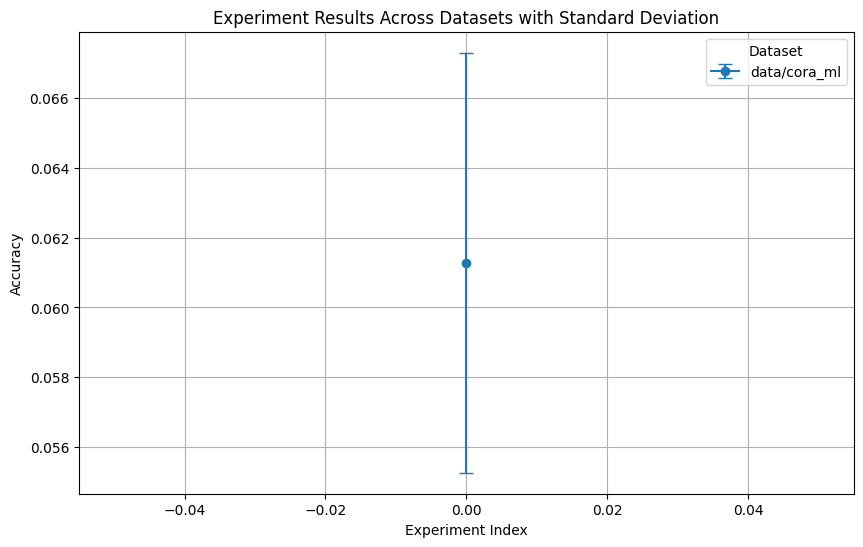

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Settings
datasets = ["data/cora_ml"]
dp_ppr_setting = [False]#, True, False, True, False, True, False, True]
dp_sgd_setting = [False]#, False, True, True, False, False, True, True]
feature_aware_setting = [False]#, False, False, False, True, True, True, True]
sigma_values = [0.15082]#, 0.08104, 0.05619, 0.04326, 0.03526, 0.02983, 0.02590]
num_runs = 5  # Run each experiment 5 times

# Collect results
results = []
for dataset in datasets:
    for i in range(len(dp_ppr_setting)):
        if dp_ppr_setting[i]:  # If DP-PPR is True, run for all sigma values
            for sigma in sigma_values:
                acc_vals, eps_vals = [], []
                for _ in range(num_runs):
                    accuracy, epsilon = run_experiment(
                        dataset, dp_ppr=True, dp_sgd=dp_sgd_setting[i], 
                        feature_aware=feature_aware_setting[i], sigma_values=sigma
                    )
                    acc_vals.append(accuracy)
                    eps_vals.append(epsilon)
                
                results.append((
                    dataset, True, dp_sgd_setting[i], feature_aware_setting[i], 
                    sigma, 
                    sum(acc_vals) / num_runs,  # Mean Accuracy
                    sum(eps_vals) / num_runs,  # Mean Epsilon
                    (sum((x - (sum(acc_vals) / num_runs))**2 for x in acc_vals) / num_runs) ** 0.5,  # Std Dev Accuracy
                    (sum((x - (sum(eps_vals) / num_runs))**2 for x in eps_vals) / num_runs) ** 0.5   # Std Dev Epsilon
                ))
        else:  # Run normally without sigma
            acc_vals, eps_vals = [], []
            for _ in range(num_runs):
                accuracy, epsilon = run_experiment(
                    dataset, dp_ppr=False, dp_sgd=dp_sgd_setting[i], 
                    feature_aware=feature_aware_setting[i]
                )
                acc_vals.append(accuracy)
                eps_vals.append(epsilon)

            results.append((
                dataset, False, dp_sgd_setting[i], feature_aware_setting[i], 
                None, 
                sum(acc_vals) / num_runs,  # Mean Accuracy
                sum(eps_vals) / num_runs,  # Mean Epsilon
                (sum((x - (sum(acc_vals) / num_runs))**2 for x in acc_vals) / num_runs) ** 0.5,  # Std Dev Accuracy
                (sum((x - (sum(eps_vals) / num_runs))**2 for x in eps_vals) / num_runs) ** 0.5   
            ))

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Dataset", "DP_PPR", "DP_SGD", "Feature_Aware", "Sigma", "Accuracy", "Epsilon", "Accuracy_Std", "Epsilon_Std"])

# Print DataFrame
print(df)

# Plot results grouped by dataset with standard deviation error bars
plt.figure(figsize=(10, 6))
for dataset, grp in df.groupby("Dataset"):
    plt.errorbar(grp.index, grp["Accuracy"], yerr=grp["Accuracy_Std"], fmt="o-", label=dataset, capsize=5)

plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Datasets with Standard Deviation")
plt.legend(title="Dataset")
plt.grid(True)
plt.show()


In [3]:
print(results)

[('data/cora_ml', False, False, False, None, 0.056940000000000004, 0.0, 0.006959482739399527, 0.0), ('data/cora_ml', True, False, False, 0.15082, 0.03285999999999999, 1.1312639491146967, 0.0015186836405255697, 0.0), ('data/cora_ml', True, False, False, 0.08104, 0.031599999999999996, 2.206053317942913, 0.006593633292806022, 0.0), ('data/cora_ml', True, False, False, 0.05619, 0.02914, 3.263939910842594, 0.0037199999999999998, 0.0), ('data/cora_ml', True, False, False, 0.04326, 0.02666, 4.313994994815165, 0.003161392098427527, 0.0), ('data/cora_ml', True, False, False, 0.03526, 0.035339999999999996, 5.363034437923216, 0.0015186836405255697, 0.0), ('data/cora_ml', True, False, False, 0.02983, 0.026039999999999997, 6.406301171609444, 0.005405034689990434, 8.881784197001252e-16), ('data/cora_ml', True, False, False, 0.0259, 0.02356, 7.442893554003019, 0.0024800000000000004, 0.0), ('data/cora_ml', False, True, False, None, 0.04084, 0.0, 0.0022878811157925148, 0.0), ('data/cora_ml', True, True

In [4]:
df
df.to_csv("experiment_results_feature_aware_5ite_r.csv", index=False)

In [5]:
cora_df = df[df["Dataset"] == "data/cora_ml"]
cora_df


,Dataset,DP_PPR,DP_SGD,Feature_Aware,Sigma,Accuracy,Epsilon,Accuracy_Std,Epsilon_Std
0,data/cora_ml,False,False,False,NaN,0.05694,0.000000,0.006959,0.000000e+00
1,data/cora_ml,True,False,False,0.15082,0.03286,1.131264,0.001519,0.000000e+00
2,data/cora_ml,True,False,False,0.08104,0.03160,2.206053,0.006594,0.000000e+00
3,data/cora_ml,True,False,False,0.05619,0.02914,3.263940,0.003720,0.000000e+00
4,data/cora_ml,True,False,False,0.04326,0.02666,4.313995,0.003161,0.000000e+00
5,data/cora_ml,True,False,False,0.03526,0.03534,5.363034,0.001519,0.000000e+00
6,data/cora_ml,True,False,False,0.02983,0.02604,6.406301,0.005405,8.881784e-16
7,data/cora_ml,True,False,False,0.02590,0.02356,7.442894,0.002480,0.000000e+00
8,data/cora_ml,False,True,False,NaN,0.04084,0.000000,0.002288,0.000000e+00
9,data/cora_ml,True,True,False,0.15082,0.02976,1.131264,0.002480,0.000000e+00


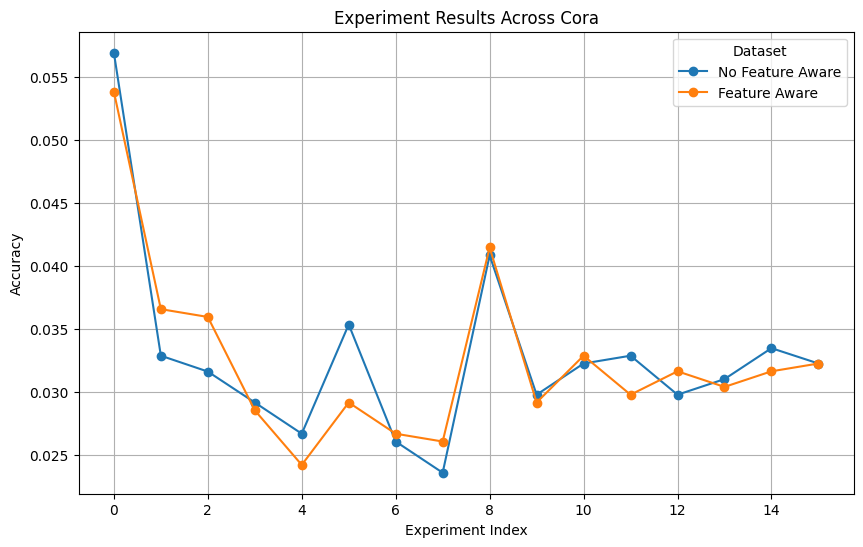

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(16), cora_df[cora_df["Feature_Aware"] == False]["Accuracy"], marker="o", linestyle="-", label='No Feature Aware')
plt.plot(range(16), cora_df[cora_df["Feature_Aware"] == True]["Accuracy"], marker="o", linestyle="-", label='Feature Aware')
plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Cora")
plt.legend(title="Dataset")
plt.grid(True)
plt.show() 

In [12]:
df

,Dataset,DP_PPR,DP_SGD,Feature_Aware,Sigma,Accuracy,Epsilon
0,data/cora_ml,False,False,False,NaN,0.69350,0.000000
1,data/cora_ml,True,False,False,0.15082,0.54178,1.131264
2,data/cora_ml,True,False,False,0.08104,0.53746,2.206053
3,data/cora_ml,True,False,False,0.05619,0.60064,3.263940
4,data/cora_ml,True,False,False,0.04326,0.55110,4.313995
5,data/cora_ml,True,False,False,0.03526,0.51580,5.363034
6,data/cora_ml,True,False,False,0.02983,0.52384,6.406301
7,data/cora_ml,True,False,False,0.02590,0.48980,7.442894
8,data/cora_ml,False,True,False,NaN,0.59072,0.000000
9,data/cora_ml,True,True,False,0.15082,0.43966,1.131264


ValueError: x and y must have same first dimension, but have shapes (16,) and (0,)

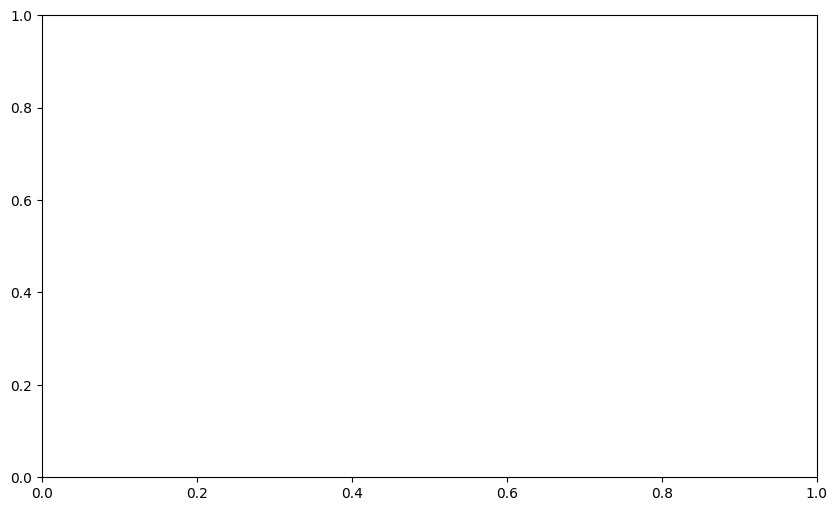

In [7]:
pubmed_df = df[df["Dataset"] == "data/pubmed"]
plt.figure(figsize=(10, 6))
plt.plot(range(16), pubmed_df[pubmed_df["Feature_Aware"] == False]["Accuracy"], marker="o", linestyle="-", label='No Feature Aware')
plt.plot(range(16), pubmed_df[pubmed_df["Feature_Aware"] == True]["Accuracy"], marker="o", linestyle="-", label='Feature Aware')
plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across pubmed")
plt.legend(title="Dataset")
plt.grid(True)
plt.show()

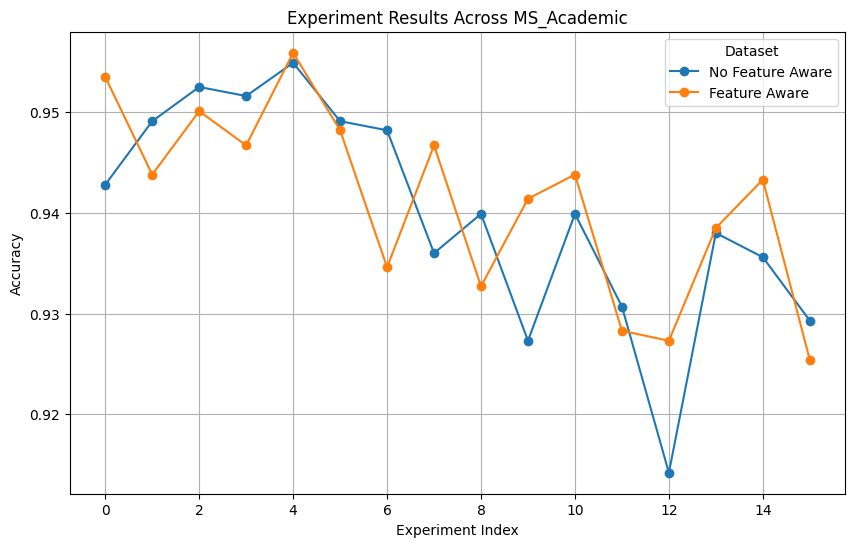

In [39]:
msa_df = df[df["Dataset"] == "data/ms_academic"]
plt.figure(figsize=(10, 6))
plt.plot(range(16), msa_df[msa_df["Feature_Aware"] == False]["Accuracy"], marker="o", linestyle="-", label='No Feature Aware')
plt.plot(range(16), msa_df[msa_df["Feature_Aware"] == True]["Accuracy"], marker="o", linestyle="-", label='Feature Aware')
plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across MS_Academic")
plt.legend(title="Dataset")
plt.grid(True)
plt.show()

Running 0
Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.13s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.09s
Training starts ... 
Training finished.
Testing accuracy: 0.0619
Epsilon :  0

Running 1
Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.22s
Finish Load Data.

No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.19s
Training starts ... 
Training finished.
Testing accuracy: 0.0341
Epsilon :  1.1312639491146967

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.23s


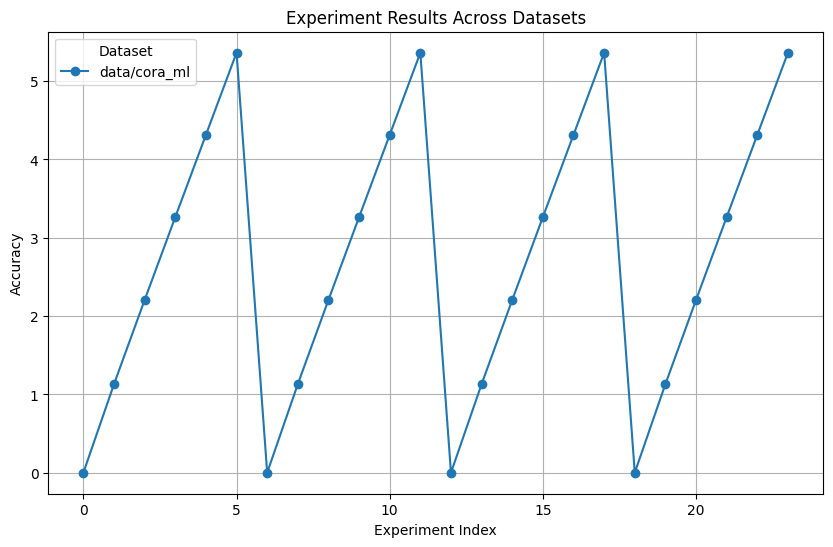

In [2]:
# Settings
datasets = ["data/cora_ml"]
dp_ppr_setting = [False, True, False, True, False, True, False, True]
dp_sgd_setting = [False, False, True, True, False, False, True, True]
gravity = [False,False,False,False,True,True,True,True]
sigma_values = [0.15082, 0.08104, 0.05619, 0.04326, 0.03526]

# Collect results
results = []
for dataset in datasets:
    for i in range(len(dp_ppr_setting)):
        print("Running",i)
        if dp_ppr_setting[i]:  # If DP-PPR is True, run for all sigma values
            for sigma in sigma_values:
                accuracy, epsilon = run_experiment(
                    dataset, dp_ppr=True, dp_sgd=dp_sgd_setting[i], sigma_values=sigma,gravity=gravity[i]
                )
                results.append((dataset, True, dp_sgd_setting[i], sigma, accuracy, epsilon,gravity[i]))
        else:  # Run normally without sigma
            accuracy, epsilon = run_experiment(
                dataset, dp_ppr=False, dp_sgd=dp_sgd_setting[i],gravity=gravity[i]
            )
            results.append((dataset, False, dp_sgd_setting[i],  None, accuracy, epsilon,gravity[i]))

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Dataset", "DP_PPR", "DP_SGD", "Feature_Aware", "Sigma", "Accuracy", "Epsilon"])

# Print DataFrame
print(df)

# Plot results grouped by dataset
plt.figure(figsize=(10, 6))
for dataset, grp in df.groupby("Dataset"):
    plt.plot(grp.index, grp["Accuracy"], marker="o", linestyle="-", label=dataset)

plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Datasets")
plt.legend(title="Dataset")
plt.grid(True)
plt.show()

         Dataset  DP_PPR  DP_SGD    Sigma  Accuracy   Epsilon  Gravity
0   data/cora_ml   False   False      NaN    0.0619  0.000000    False
1   data/cora_ml    True   False  0.15082    0.0341  1.131264    False
2   data/cora_ml    True   False  0.08104    0.0372  2.206053    False
3   data/cora_ml    True   False  0.05619    0.0217  3.263940    False
4   data/cora_ml    True   False  0.04326    0.0248  4.313995    False
5   data/cora_ml    True   False  0.03526    0.0279  5.363034    False
6   data/cora_ml   False    True      NaN    0.0341  0.000000    False
7   data/cora_ml    True    True  0.15082    0.0310  1.131264    False
8   data/cora_ml    True    True  0.08104    0.0310  2.206053    False
9   data/cora_ml    True    True  0.05619    0.0341  3.263940    False
10  data/cora_ml    True    True  0.04326    0.0341  4.313995    False
11  data/cora_ml    True    True  0.03526    0.0341  5.363034    False
12  data/cora_ml   False   False      NaN    0.0743  0.000000     True
13  da

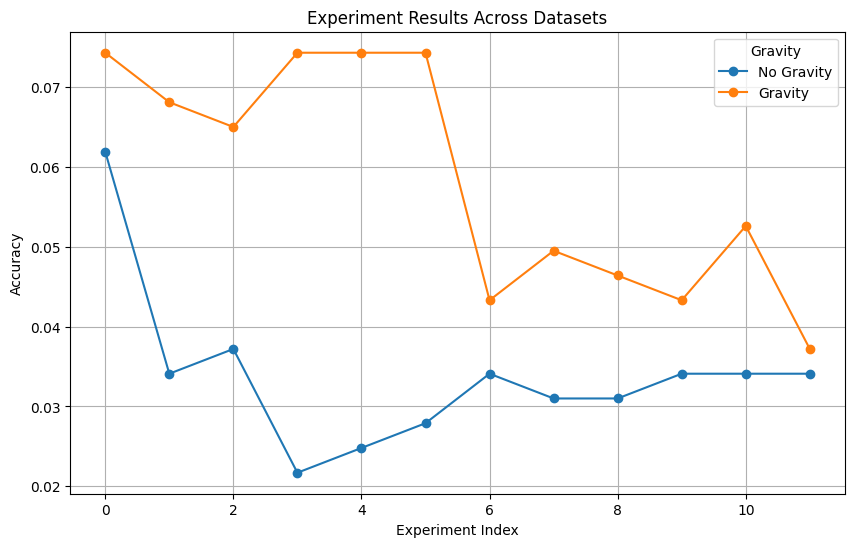

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame(results, columns=["Dataset", "DP_PPR", "DP_SGD", "Sigma", "Accuracy", "Epsilon", "Gravity"])
df.to_csv("experiment_results_cora_gravity.csv", index=False)
# Print DataFrame
print(df)

# Ensure Gravity column is treated as boolean
df["Gravity"] = df["Gravity"].astype(bool)

# Separate into two DataFrames based on Gravity
df_nograv = df[df['Gravity'] == False]
df_grav = df[df['Gravity'] == True]

print(df_grav)

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(df_nograv.index, df_nograv["Accuracy"], marker="o", linestyle="-", label="No Gravity")
plt.plot(df_grav.index-12, df_grav["Accuracy"], marker="o", linestyle="-", label="Gravity")

plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Datasets")
plt.legend(title="Gravity")
plt.grid(True)
plt.show()


Running 0
Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.10s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.07s
Training starts ... 
Training finished.
Testing accuracy: 0.0557
Epsilon :  0

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.12s
Finish Load Data.

No DP for calculating PPR
No DP when doing SGD
Calculate Train PPR Matrix Runtime: 0.09s
Training starts ... 
Training finished.
Testing accuracy: 0.0526
Epsilon :  0

Running experiment with data_file=data/cora_ml
Loading cora_ml.npz graph with #nodes=2995, #attributes=2879, #classes=7
THIS METIS_Options(seed=0)
[   0    4    6 ... 2989 2990 2993]
(211,)
Runtime: 0.11s
F

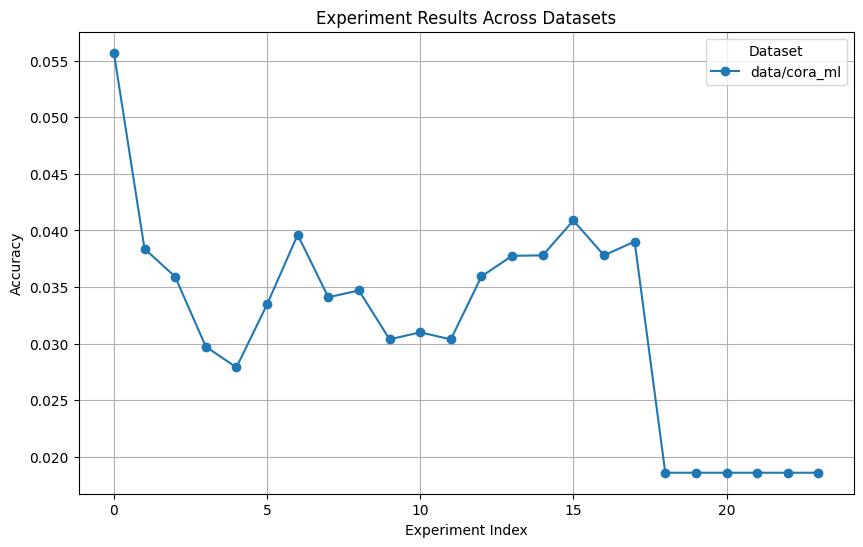

In [4]:
# Settings
import numpy as np

datasets = ["data/cora_ml"]
dp_ppr_setting = [False, True, False, True, False, True, False, True]
dp_sgd_setting = [False, False, True, True, False, False, True, True]
heat = [False,False,False,False,True,True,True,True]
sigma_values = [0.15082, 0.08104, 0.05619, 0.04326, 0.03526]

# Collect results
results = []
for dataset in datasets:
    for i in range(len(dp_ppr_setting)):
        print("Running", i)
        if dp_ppr_setting[i]:
            for sigma in sigma_values:
                acc_list, eps_list = [], []
                for _ in range(5): 
                    accuracy, epsilon = run_experiment(
                        dataset, dp_ppr=True, dp_sgd=dp_sgd_setting[i], sigma_values=sigma, heat=heat[i]
                    )
                    acc_list.append(accuracy)
                    eps_list.append(epsilon)
                results.append((dataset, True, dp_sgd_setting[i], sigma, np.mean(acc_list), np.mean(eps_list), heat[i]))
        else:  
            acc_list, eps_list = [], []
            for _ in range(5): 
                accuracy, epsilon = run_experiment(
                    dataset, dp_ppr=False, dp_sgd=dp_sgd_setting[i], heat=heat[i]
                )
                acc_list.append(accuracy)
                eps_list.append(epsilon)
            results.append((dataset, False, dp_sgd_setting[i], None, np.mean(acc_list), np.mean(eps_list), heat[i]))

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Dataset", "DP_PPR", "DP_SGD", "Sigma", "Accuracy", "Epsilon", "Heat"])

# Print DataFrame
print(df)

# Plot results grouped by dataset
plt.figure(figsize=(10, 6))
for dataset, grp in df.groupby("Dataset"):
    plt.plot(grp.index, grp["Accuracy"], marker="o", linestyle="-", label=dataset)

plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Datasets")
plt.legend(title="Dataset")
plt.grid(True)
plt.show()

In [5]:
df.to_csv("experiment_results_cora_Q.csv", index=False)

         Dataset  DP_PPR  DP_SGD    Sigma  Accuracy   Epsilon  Heat
12  data/cora_ml   False   False      NaN   0.03594  0.000000  True
13  data/cora_ml    True   False  0.15082   0.03776  1.131264  True
14  data/cora_ml    True   False  0.08104   0.03780  2.206053  True
15  data/cora_ml    True   False  0.05619   0.04088  3.263940  True
16  data/cora_ml    True   False  0.04326   0.03780  4.313995  True
17  data/cora_ml    True   False  0.03526   0.03902  5.363034  True
18  data/cora_ml   False    True      NaN   0.01860  0.000000  True
19  data/cora_ml    True    True  0.15082   0.01860  1.131264  True
20  data/cora_ml    True    True  0.08104   0.01860  2.206053  True
21  data/cora_ml    True    True  0.05619   0.01860  3.263940  True
22  data/cora_ml    True    True  0.04326   0.01860  4.313995  True
23  data/cora_ml    True    True  0.03526   0.01860  5.363034  True


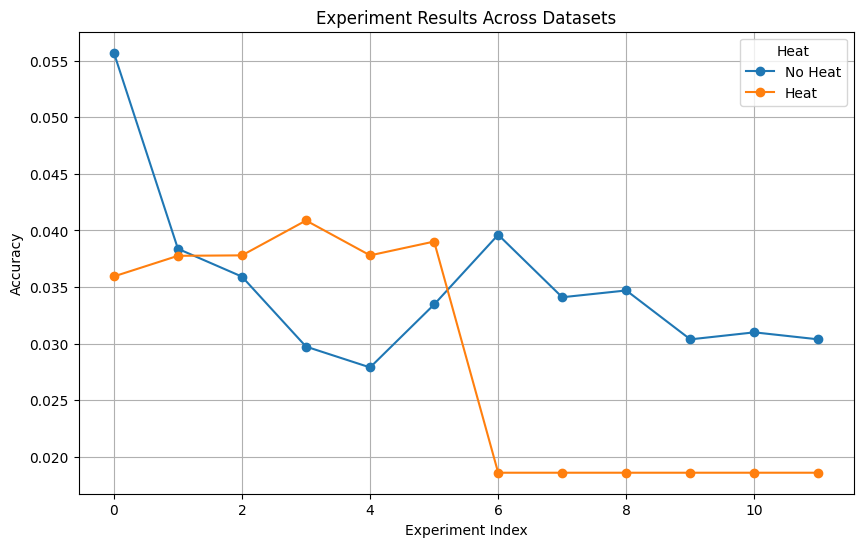

In [6]:
df["Heat"] = df["Heat"].astype(bool)

# Separate into two DataFrames based on Heat
df_nograv = df[df['Heat'] == False]
df_grav = df[df['Heat'] == True]

print(df_grav)

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(df_nograv.index, df_nograv["Accuracy"], marker="o", linestyle="-", label="No Heat")
plt.plot(df_grav.index-12, df_grav["Accuracy"], marker="o", linestyle="-", label="Heat")

plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Experiment Results Across Datasets")
plt.legend(title="Heat")
plt.grid(True)
plt.show()